#Project - Traffic sign recognition

First, a baseline model for classification of road signs will be constructed. The model will use a deep Convolutional Neural Network (CNN). The metric used to asses performance will be the Area Under the Receiver Operating Characteristics Curve (AUC). A Generative Adversarial Network (GAN) model will then be used to train a generator to create new accurate training samples. The original model will then be retrained with the larger training set. The performance before and after generating more samples with the GAN will be compared. 

The German Traffic Sign Recognition Benchmark (GTSRB) dataset will be used. 
It consists of 50,000 images of 40 different traffic signs.
https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign


1. Load The Data
2. Data Preprocessing.
  - Shuffling.
  - Grayscaling.
  - Local Histogram Equalization.
  - Normalization.
3. CNN Model Architecture design 
  - VGGNet.
4. Model Training and Evaluation.
5. Testing the Model Using the Test Set.
6. GAN Model Architecture design: https://towardsdatascience.com/generative-adversarial-network-gan-for-dummies-a-step-by-step-tutorial-fdefff170391#:~:text=GAN%20Training&text=Step%201%20%E2%80%94%20Select%20a%20number,both%20fake%20and%20real%20images.

  - The  model consists of:
    - A **discriminator**, consisting on a CNN pretrained for Traffic sign Image classification 
    - A **generator**, 

The joined DCGAN is built by adding the discriminator on the top of the generator. Before compiling the full setup, we have to set the discriminator model not to be trainable. This will freeze its weights and tell that the only part of the full network that needs to be trained is the generator.
Although we compile the discriminator we don’t need to compile the generator model because we do not use the generator on its own.
This order ensures that the discriminator is updated at the right time and frozen when it has to be. Therefore if we train the whole model, it will just update the generator, and when we train the discriminator, it will only update the discriminator.

7. Train the GAN
  1. Select a number of real images from the training set.
  2.  Generate a number of fake images. This is done by sampling random noise vectors and creating images from them using the generator.
  3. Train the discriminator for one or more epochs using both fake and real images. This will update only the discriminator’s weights by labeling all the real images as 1 and the fake images as 0.
  4. Generate another number of fake images.
  5. Train the full GAN model for one or more epochs using only fake images. This will update only the generator’s weights by labeling all fake images as 1.

8. Data augmentation using GAN
9. Augmented Model Training and Evaluation
10. Testing the model on test set and new images
11. Performance comparison of the two models (CNN only and CNN + GAN)



In [ ]:
# load required packages
#%pip install pyspark
#%pip install pillow
#%pip install keras
#%pip install tensorflow-cpu==2.3.*
#%pip install graphviz
#%pip install pydot

# 1. Prepare the dataset
### 1.1 Load the traffic sign dataset (zip format)
 GTSRB Dataset was chosen because it's small size is beneficial for building and running models on our personal machines. 


In [ ]:
#import libraries
import string
import os
import pickle
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import skimage.morphology as morp
from skimage.filters import rank
from sklearn.utils import shuffle
from keras.preprocessing.image import load_img, img_to_array
from keras import optimizers, regularizers
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.models import Sequential
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dropout, Dense, LSTM, Embedding, Add, Conv2D, Flatten, MaxPooling2D, Activation
from keras.preprocessing.text import Tokenizer
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.applications.inception_v3 import InceptionV3, \
        preprocess_input
from tensorflow.keras.layers import Flatten
from tensorflow.python.keras.engine import training
from sklearn.metrics import confusion_matrix

# is it using the GPU?
print(tf.test.gpu_device_name())

# Show current TensorFlow version
tf.__version__

# Load the dataset directly using the links. 
import os
import glob
import pandas as pd

#import libraries for preprocessing data
import cv2

/device:GPU:0


In [ ]:
from tensorflow.keras.initializers import RandomNormal


In [ ]:
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

from keras.layers import Input, Reshape
from keras.layers import BatchNormalization, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, load_model


In [ ]:
try:
  os.remove('traffic-signs-data.zip')
  os.listdir()
except:
  os.listdir()

!wget https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
  
os.listdir()



--2021-01-30 10:32:03--  https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 99.86.227.60, 99.86.227.5, 99.86.227.118, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|99.86.227.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘traffic-signs-data.zip’

traffic-signs-data. 100%[===================>] 117.80M  64.6MB/s    in 1.8s    

2021-01-30 10:32:05 (64.6 MB/s) - ‘traffic-signs-data.zip’ saved [123524425/123524425]



['.config', 'traffic-signs-data.zip', 'signnames.csv', 'sample_data']

In [ ]:
# unzip the folders downloaded in previous step. 
import zipfile
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "traffic-signs-data.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    print('Extracting all the files now...') 
    zip.extractall("traffic-signs-data") 
    print('Done!')


Extracting all the files now...
Done!


In [ ]:
# Mapping ClassID to traffic sign names
# Importing signnames.csv "by hand", cause the one dowloaded directly from Github gets corrupted
try:
  #os.remove('signnames.csv')
  os.listdir()
except:
  os.listdir()

In [ ]:
#divide data into validation training and test

training_file = "./traffic-signs-data/train.p"
validation_file= "./traffic-signs-data/valid.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

os.listdir('./traffic-signs-data')

['valid.p', 'train.p', 'test.p']

In [ ]:
# Mapping ClassID to traffic sign names
signs = []

with open('signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    print(signnames)
    for row in signnames:
      signs.append(row[1])
    csvfile.close()
print(signs)


['Speed limit (20km/h);;', 'Speed limit (30km/h);;', 'Speed limit (50km/h);;', 'Speed limit (60km/h);;', 'Speed limit (70km/h);;', 'Speed limit (80km/h);;', 'End of speed limit (80km/h);;', 'Speed limit (100km/h);;', 'Speed limit (120km/h);;', 'No passing;;', 'No passing for vehicles over 3.5 metric tons;;', 'Right-of-way at the next intersection;;', 'Priority road;;', 'Yield;;', 'Stop;;', 'No vehicles;;', 'Vehicles over 3.5 metric tons prohibited;;', 'No entry;;', 'General caution;;', 'Dangerous curve to the left;;', 'Dangerous curve to the right;;', 'Double curve;;', 'Bumpy road;;', 'Slippery road;;', 'Road narrows on the right;;', 'Road work;;', 'Traffic signals;;', 'Pedestrians;;', 'Children crossing;;', 'Bicycles crossing;;', 'Beware of ice/snow;;', 'Wild animals crossing;;', 'End of all speed and passing limits;;', 'Turn right ahead;;', 'Turn left ahead;;', 'Ahead only;;', 'Go straight or right;;', 'Go straight or left;;', 'Keep right;;', 'Keep left;;', 'Roundabout mandatory;;', 

In [ ]:
type(signs)

list

### 1.2. Dataset infos

In [ ]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples
n_test = X_test.shape[0]

# Number of validation examples.
n_validation = X_valid.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples: ", n_train)
print("Number of testing examples: ", n_test)
print("Number of validation examples: ", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples:  34799
Number of testing examples:  12630
Number of validation examples:  4410
Image data shape = (32, 32, 3)
Number of classes = 43


### 1.3 Plotting some images in the dataset

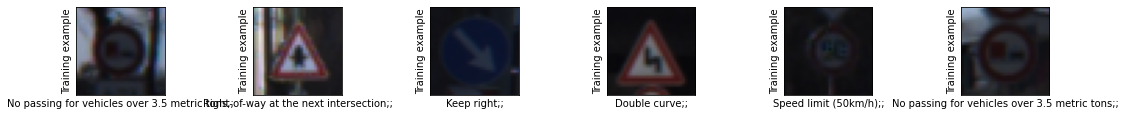

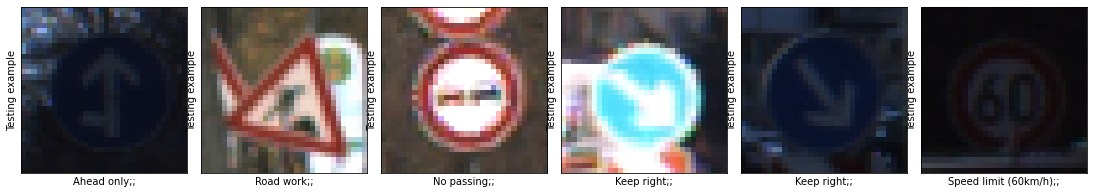

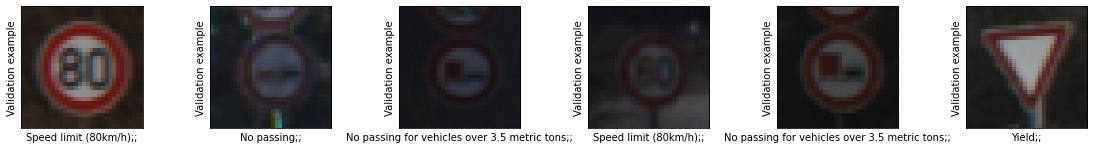

In [ ]:
def list_images(dataset, dataset_y, ylabel="", cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: An np.array compatible with plt.imshow.
            lanel (Default = No label): A string to be used as a label for each image.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(dataset))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap = cmap)
        plt.xlabel(signs[dataset_y[indx]])
        plt.ylabel(ylabel)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

# Plotting sample examples
list_images(X_train, y_train, "Training example")
list_images(X_test, y_test, "Testing example")
list_images(X_valid, y_valid, "Validation example")

## 2. Data preprocessing
###2.1 Shuffling
Shuffling is a data preprocessing technique to increase randomness and variety in training dataset. This action permits the model to be more stable. We will use sklearn to shuffle our data.

In [ ]:
X_train, y_train = shuffle(X_train, y_train)

###2.2. Grayscaling
 In their paper "Traffic Sign Recognition with Multi-Scale Convolutional Networks" published in 2011, P. Sermanet and Y. LeCun stated that using grayscale images instead of color improves the ConvNet's accuracy. We will use OpenCV to convert the training images into grey scale.

In [ ]:
def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
   # image = cv2.resize(image,(224, 224),3)
    
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

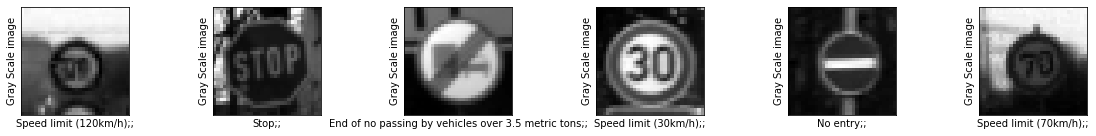

In [ ]:
# Sample images after greyscaling
gray_images = list(map(gray_scale, X_train))
list_images(gray_images, y_train, "Gray Scale image", "gray")

###2.3. Local Histogram Equalization
This technique simply spreads out the most frequent intensity values in an image, resulting in enhancing images with low contrast. Applying this technique will be very helpfull in our case since the dataset in hand has real world images, and many of them has low contrast. We will use skimage to apply local histogram equalization to the training images.


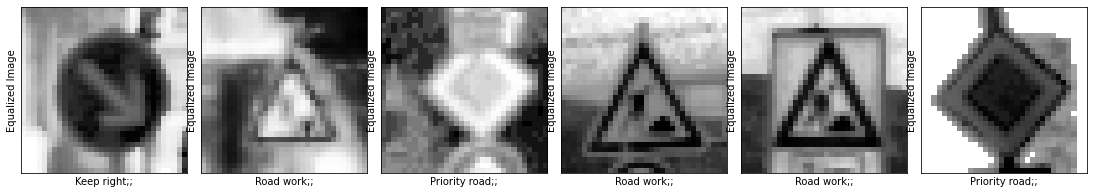

In [ ]:
def local_histo_equalize(image):
    """
    Apply local histogram equalization to grayscale images.
        Parameters:
            image: A grayscale image.
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local
# Sample images after Local Histogram Equalization
equalized_images = list(map(local_histo_equalize, gray_images))
list_images(equalized_images, y_train, "Equalized Image", "gray")

###2.4 Normalization
Normalization is a process that changes the range of pixel intensity values. Usually the image data should be normalized so that the data has mean zero and equal variance.


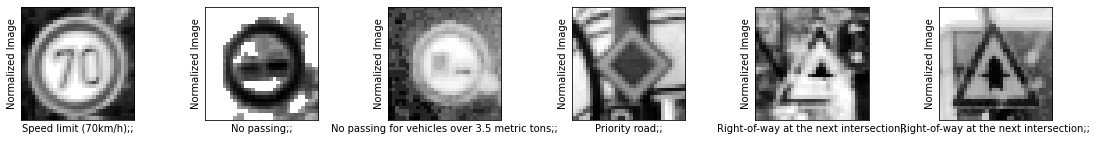

In [ ]:
def image_normalize(image):
    """
    Normalize images to [0, 1] scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    image = np.divide(image, 255)
    return image
# Sample images after normalization
n_training = X_train.shape
normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))

for i, img in enumerate(equalized_images):
    normalized_images[i] = image_normalize(img)
list_images(normalized_images, y_train, "Normalized Image", "gray")
normalized_images = normalized_images[..., None]

In [ ]:
def preprocess(data):
    """
    Applying the preprocessing steps to the input data.
        Parameters:
            data: An np.array compatible with plt.imshow.
    """
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = image_normalize(img)
    normalized_images = normalized_images[..., None]
    return normalized_images

In [ ]:
X_train.shape

(34799, 32, 32, 3)

In [ ]:
normalized_images.shape

(34799, 32, 32, 1)

In [ ]:
y_train.shape

(34799,)

##3. Design the CNN model
The CNN model designed is the VGGNet. It was first introduced in 2014 by K. Simonyan and A. Zisserman from the University of Oxford in a paper called Very Deep Convolutional Networks for Large-Scale Image Recognition. They were investigating the convolutional network depth on its accuracy in the large-scale image recognition setting. Their main contribution is a thorough evaluation of networks of increasing depth using an architecture with very small (3x3) convolution filters, which shows that a significant improvement on the prior-art configurations can be achieved by pushing the depth to 16-19 weight layers.


In [ ]:
def build_model():
  model = Sequential()

  # Layer 1 (Convolutional): Input = 32x32x1. Output = 32x32x32.
  model.add(Conv2D(32, (3, 3), padding='same',
                    input_shape=(32,32,1)))
  model.add(Activation('relu'))

  # Layer 2 (Convolutional): The output shape should be 32x32x32.
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('relu'))

  # Layer 3 (Pooling) The output shape should be 16x16x32.
  model.add(MaxPooling2D(pool_size=( 2, 2)))
  model.add(Dropout(0.25))
  
  # Layer 4 (Convolutional): Input = 16x16x32. Output = 16x16x64.
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))

  # Layer 5 (Convolutional): Input = 16x16x64. Output = 16x16x64.
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  
  # Layer 6 (Pooling): Input = 16x16x64. Output = 8x8x64.
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # Layer 7 (Convolutional): Input = 8x8x64. Output = 8x8x128.
  model.add(Conv2D(128, (3, 3),padding = 'same'))
  model.add(Activation('relu'))

  # Layer 8 (Convolutional): Input = 8x8x128. Output = 8x8x128.
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  
  # Layer 9 (Pooling): Input = 8x8x128. Output = 4x4x128.
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # Flatten. Input = 4x4x128. Output = 2048. 
  # Flatten the output shape of the final pooling layer such that it's 1D instead of 3D
  model.add(Flatten())
  
  # Layer 10 (Fully Connected): Input = 2048. Output = 128.
  model.add(Dense(units = 128, activation ='relu'))
  model.add(Dropout(0.5))

  # Layer 11 (Fully Connected): Input = 128. Output = 128.
  model.add(Dense(units = 128, activation ='relu'))
  model.add(Dropout(0.5))

  # Layer 12 (Fully Connected): Input = 128. Output = n_out. (should be 43)
  model.add(Dense(units = 43, activation ='softmax'))

  # Let's train the model using RMSprop
  model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
            # metrics=[tf.keras.metrics.AUC()])

  print(model.summary())
  plot_model(model, to_file='convolutional_neural_network.png')

  return model

In [ ]:
cnn_model = build_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

## 4. Train the CNN model



In [ ]:
# the labels need to be one hot encoded
y_train_onehot = tf.one_hot(y_train, n_classes)
y_train_onehot[1]

<tf.Tensor: shape=(43,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [ ]:
normalized_images.shape

(34799, 32, 32, 1)

In [ ]:
# Validation set preprocessing
X_valid_preprocessed = preprocess(X_valid)
y_valid_one_hot = tf.one_hot(y_valid, n_classes)

In [ ]:
# train the model, run epochs manually and save after each epoch
epochs = 10
for i in range(epochs):
  # fit for one epoch
  cnn_model.fit(normalized_images,y_train_onehot,epochs=1, verbose=1)
  cnn_model.save('cnn_model_' + str(i) + '.h5')

 505/1088 [============>.................] - ETA: 2s - loss: 0.0949 - accuracy: 0.9747

KeyboardInterrupt: ignored

## 5. Validation

In [ ]:
# Validation set preprocessing
X_valid_preprocessed = preprocess(X_valid)
y_valid_one_hot = tf.one_hot(y_valid, n_classes)

In [ ]:
for i in range(10):
  filename = 'cnn_model_' + str(i) + '.h5'
  cnn_model = load_model(filename)
  print(filename)
  validation_accuracy = cnn_model.evaluate(X_valid_preprocessed, y_valid_one_hot)

cnn_model_0.h5
138/138 [==============================] - 1s 4ms/step - loss: 1.0068 - accuracy: 0.6485
cnn_model_1.h5
138/138 [==============================] - 1s 3ms/step - loss: 0.3585 - accuracy: 0.8574
cnn_model_2.h5
138/138 [==============================] - 1s 3ms/step - loss: 0.1941 - accuracy: 0.9347
cnn_model_3.h5
138/138 [==============================] - 1s 3ms/step - loss: 0.1653 - accuracy: 0.9381
cnn_model_4.h5
138/138 [==============================] - 1s 3ms/step - loss: 0.1113 - accuracy: 0.9676
cnn_model_5.h5
138/138 [==============================] - 1s 3ms/step - loss: 0.0809 - accuracy: 0.9737
cnn_model_6.h5
138/138 [==============================] - 1s 3ms/step - loss: 0.0656 - accuracy: 0.9748
cnn_model_7.h5
138/138 [==============================] - 1s 3ms/step - loss: 0.0561 - accuracy: 0.9857
cnn_model_8.h5
138/138 [==============================] - 1s 3ms/step - loss: 0.0599 - accuracy: 0.9859
cnn_model_9.h5
138/138 [==============================] - 1s 3ms

The model that achieves higher accuracy is the one trained on 8 epochs: cnn_model_7.h5

##6. Tesing on test set

In [ ]:
# Test set preprocessing
X_test_preprocessed = preprocess(X_test)

In [ ]:
filename = 'cnn_model_' + '7' + '.h5'
cnn_model = load_model(filename)
#y_pred = []
#for i in range(200):
#  y_pred.append(np.argmax(cnn_model.predict(X_test_preprocessed)[i]))

In [ ]:
#show some predicted images from the test set
#list_images(X_test[0:i], y_pred, "Prediction on test")

In [ ]:
#test_accuracy = np.sum(np.array(y_pred[0:i]) == y_test[0:i])/len(y_test[0:i])
#print("Test Accuracy on", i ,"samples =",test_accuracy*100)